In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [4]:
N_YEARS = 20
N_CUTS = 4
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('2002-04-17', datetime.date(2022, 4, 17))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


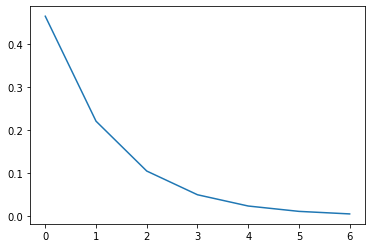

In [5]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [6]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD

0.46566128730773904

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = [
    '^GSPC', # S&P 500
    '^IXIC', # Nasdaq
    '^NYA',  # NY Stock Exchange (total)
    '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [
    (first, second)
    for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
    for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-04-08  19.043186  7.402860  19.043186  7.402860  19.043186  7.402860   
2022-04-11  18.852863  7.262342  18.852863  7.262342  18.852863  7.262342   
2022-04-12  18.689837  7.176103  18.689837  7.176103  18.689837  7.176103   
2022-04-13  19.243916  7.359597  19.243916  7.359597  19.243916  7.359597   
2022-04-14  18.657302  7.120408  18.657302  7.120408  18.657302  7.120408   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-04-08  19.043186  7.402860  19.043186  7.402860  
2022-04-11  18.852863  7.262342  18.852863  7.262342  
2022-04-12  18.689837  7.176103  18.689837  7.176103  
2022-04-13  19.243916  7.359597  19.243916  7.359597  
2022-04-14  18.657302  7.120408  18.657302  7.120408

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                                                Close  \
         ^GSPC        ^IXIC         ^NYA        ^W5000        ^GSPC   
0  1126.069946  1810.670044  6275.299805  10642.509766  1126.069946   
1  1124.469971  1802.430054  6269.689941  10628.540039  1124.469971   
2  1125.170044  1796.829956  6278.470215  10635.049805  1125.170044   
3  1107.829956  1758.680054  6196.729980  10478.660156  1107.829956   
4  1100.959961  1730.290039  6178.229980  10425.009766  1100.959961   

                                                  High               ...  \
         ^IXIC         ^NYA        ^W5000        ^GSPC        ^IXIC  ...   
0  1810.670044  6275.299805  10642.509766  1133.000000  1832.010010  ...   
1  1802.430054  6269.689941  10628.540039  1130.489990  1818.790039  ...   
2  1796.829956  6278.470215  10635.049805  1128.819946  1816.619995  ...   
3  1758.680054  6196.729980  10478.660156  1125.170044  1779.180054  ...   
4  1730.290039  6178.229980  10425.009766  1111.170044  1762.939941  ...   

  DayToDayChange OvernightChange LogValue IntradayChange DayToDayChange  \
          ^W5000          ^W5000    mine1          mine1          mine1   
0            NaN             NaN      NaN            NaN            NaN   
1       0.998687        0.998687      NaN            NaN            NaN   
2       1.000612        1.000612      NaN            NaN            NaN   
3       0.985295        0.985295      NaN            NaN            NaN   
4       0.994880        0.994880      NaN            NaN            NaN   

  OvernightChange LogValue IntradayChange DayToDayChange OvernightChange  
            mine1    mine2          mine2          mine2           mine2  
0             NaN      NaN            NaN            NaN             NaN  
1             NaN      NaN            NaN            NaN             NaN  
2             NaN      NaN            NaN            NaN             NaN  
3             NaN      NaN            NaN            NaN             NaN  
4             NaN      NaN            NaN            NaN             NaN  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

5031   2022-04-08
5032   2022-04-11
5033   2022-04-12
5034   2022-04-13
5035   2022-04-14
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                                                Close  \
                  ^GSPC        ^IXIC         ^NYA        ^W5000        ^GSPC   
Date                                                                           
2002-04-17  1126.069946  1810.670044  6275.299805  10642.509766  1126.069946   
2002-04-18  1124.469971  1802.430054  6269.689941  10628.540039  1124.469971   
2002-04-19  1125.170044  1796.829956  6278.470215  10635.049805  1125.170044   
2002-04-22  1107.829956  1758.680054  6196.729980  10478.660156  1107.829956   
2002-04-23  1100.959961  1730.290039  6178.229980  10425.009766  1100.959961   

                                                           High               \
                  ^IXIC         ^NYA        ^W5000        ^GSPC        ^IXIC   
Date                                                                           
2002-04-17  1810.670044  6275.299805  10642.509766  1133.000000  1832.010010   
2002-04-18  1802.430054  6269.689941  10628.540039  1130.489990  1818.790039   
2002-04-19  1796.829956  6278.470215  10635.049805  1128.819946  1816.619995   
2002-04-22  1758.680054  6196.729980  10478.660156  1125.170044  1779.180054   
2002-04-23  1730.290039  6178.229980  10425.009766  1111.170044  1762.939941   

            ... DayToDayChange OvernightChange LogValue IntradayChange  \
            ...         ^W5000          ^W5000    mine1          mine1   
Date        ...                                                          
2002-04-17  ...            NaN             NaN      NaN            NaN   
2002-04-18  ...       0.998687        0.998687      NaN            NaN   
2002-04-19  ...       1.000612        1.000612      NaN            NaN   
2002-04-22  ...       0.985295        0.985295      NaN            NaN   
2002-04-23  ...       0.994880        0.994880      NaN            NaN   

           DayToDayChange OvernightChange LogValue IntradayChange  \
                    mine1           mine1    mine2          mine2   
Date                                                                
2002-04-17            NaN             NaN      NaN            NaN   
2002-04-18            NaN             NaN      NaN            NaN   
2002-04-19            NaN             NaN      NaN            NaN   
2002-04-22            NaN             NaN      NaN            NaN   
2002-04-23            NaN             NaN      NaN            NaN   

           DayToDayChange OvernightChange  
                    mine2           mine2  
Date                                       
2002-04-17            NaN             NaN  
2002-04-18            NaN             NaN  
2002-04-19            NaN             NaN  
2002-04-22            NaN             NaN  
2002-04-23            NaN             NaN  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(
            f'Unexpected error getting {stock} data. Initialized as '
            f'None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'w') as f:
        json.dump(best_param_set, f)

In [20]:
SDS

array([0.46566129, 0.2213282 , 0.10519701, 0.05      , 0.02376493,
       0.01129544, 0.00536871])

SD: 0.2213282



----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.4174803310684734
Refitting current best...
Current best ma returns: 3.636095234433213
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 3.6369794042357104
Invested: 1.0
New best: 3.6532158336348375
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.4174803310684734
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 3.4174803310684734
Refitting c

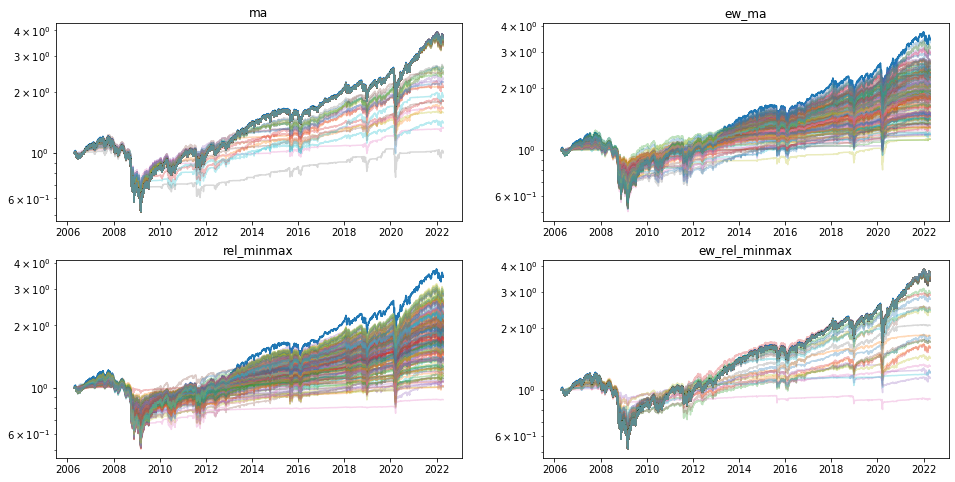

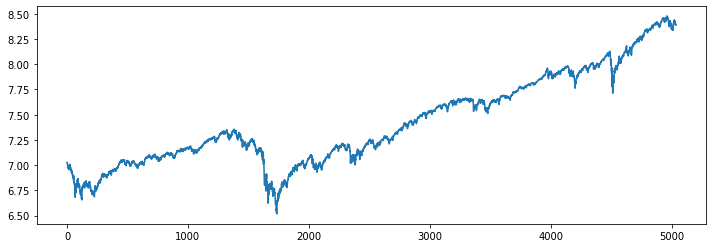

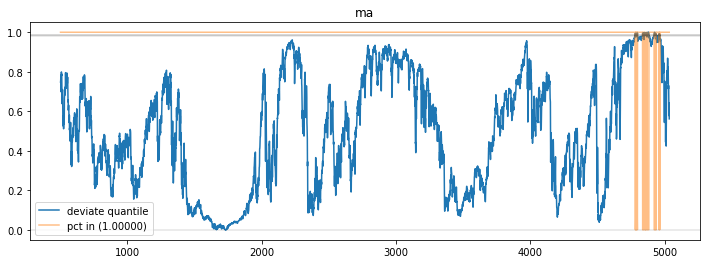

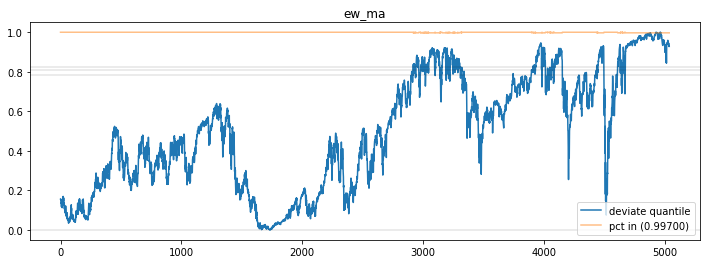

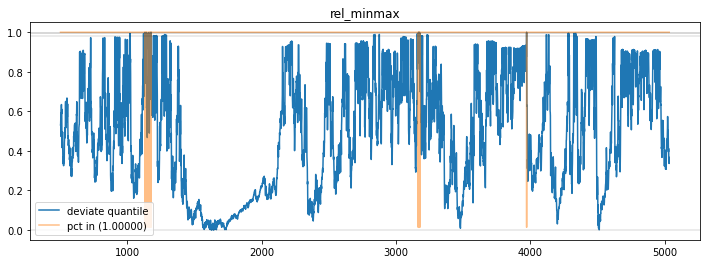

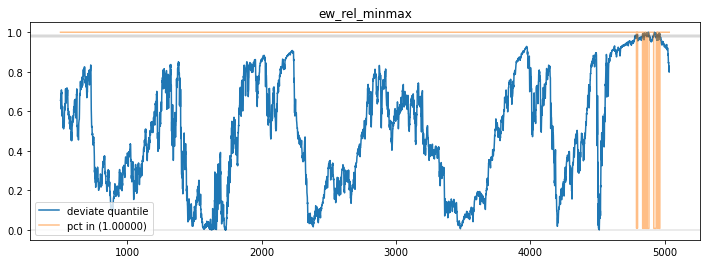

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 5.776787667600027
Refitting current best...
Current best ma returns: 6.414681144790815
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 5.776787667600027
Refitting current best...
Current best ew_ma returns: 6.694794704082763
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 5.776787667600027
Refitting current best...
Fraction Invested: 1
Beginning random search...
Roun

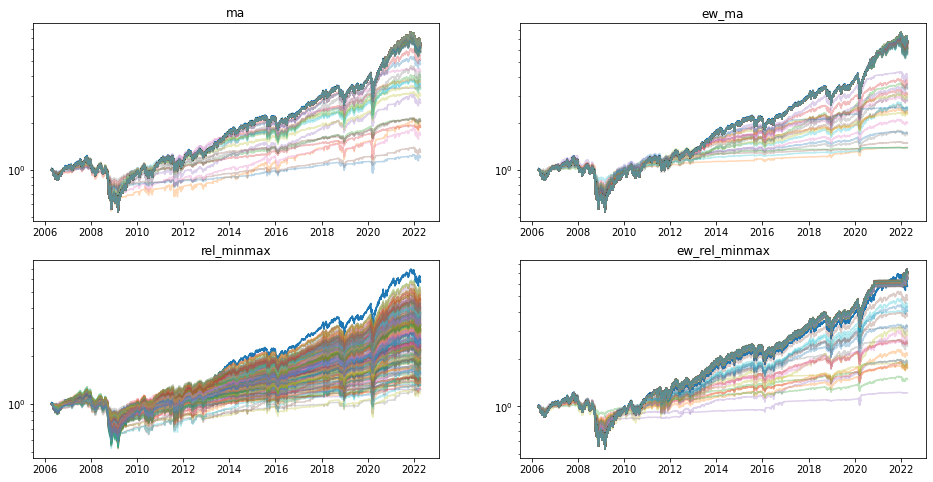

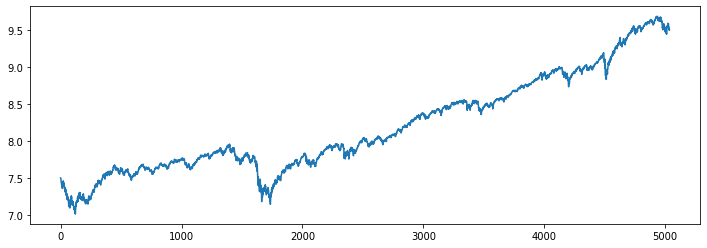

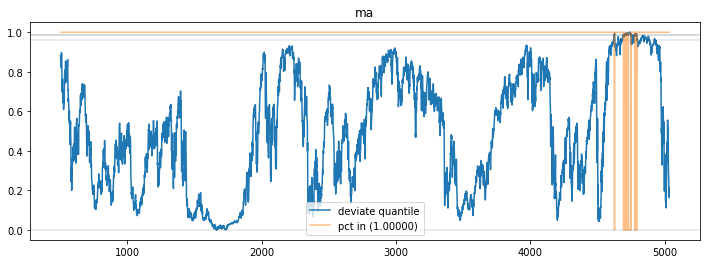

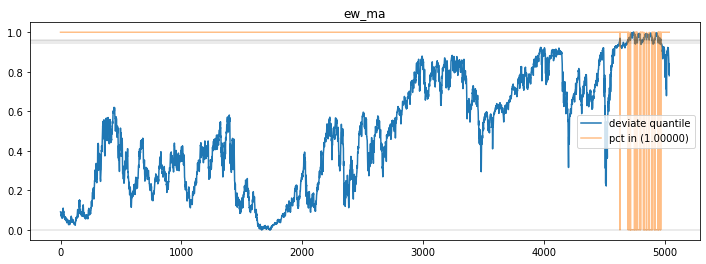

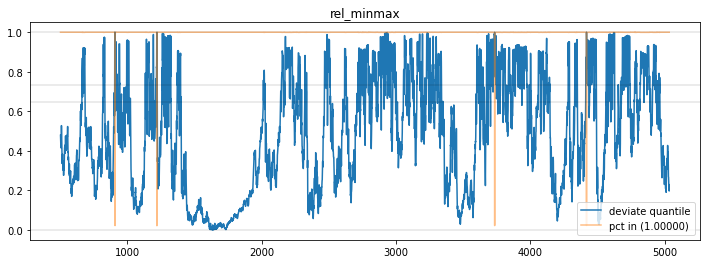

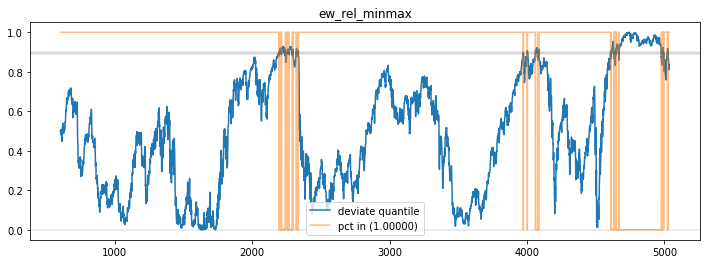

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.0033011996973444
Refitting current best...
Current best ma returns: 2.588489690256877
Fraction Invested: 0.9999999514344489
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 2.588493433777816
Invested: 0.9999999514344489
New best: 2.5884998566810364
Invested: 0.9999999514344489
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.0033011996973444
Refitting current best...
Current best ew_ma returns: 2.339667683492568
Fraction Invested: 0.8578891501622188
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
---------------------

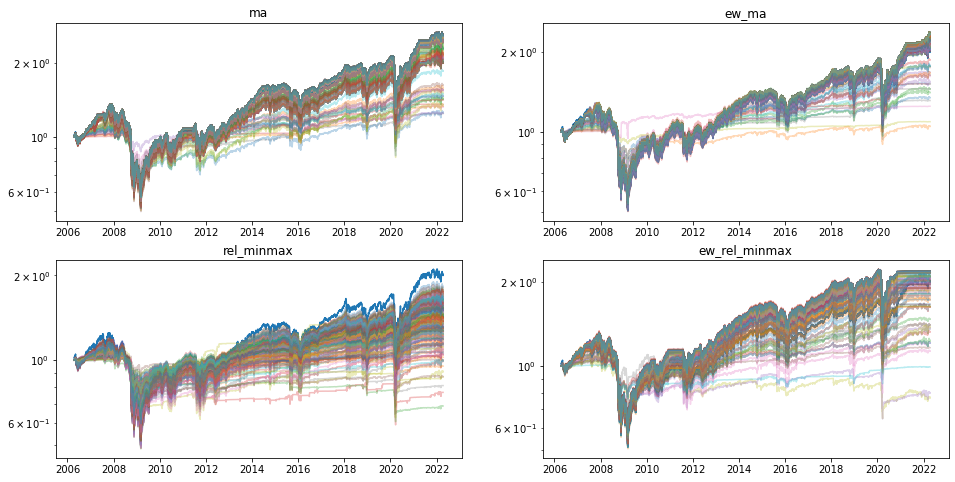

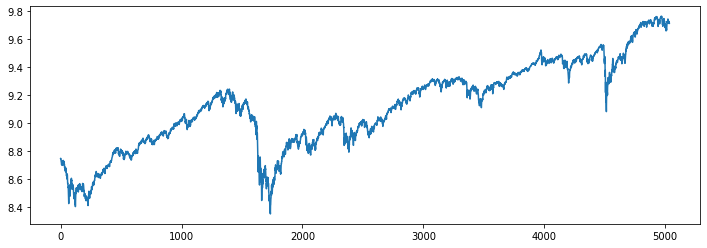

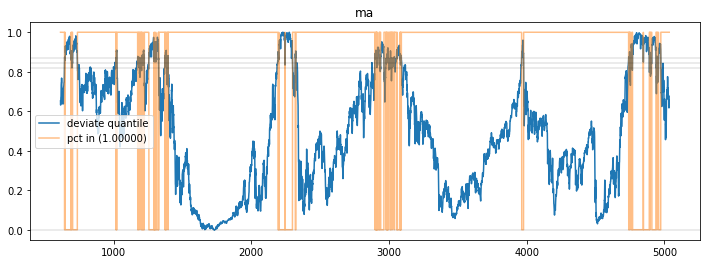

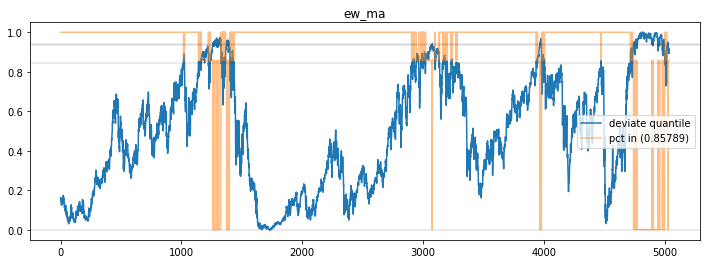

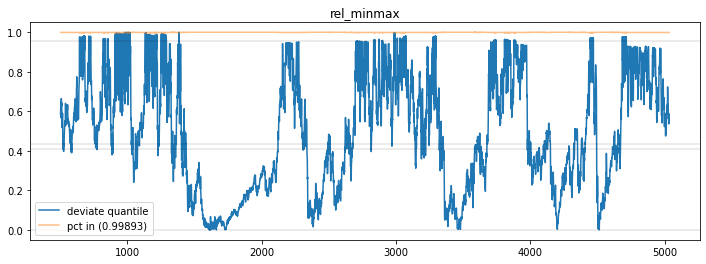

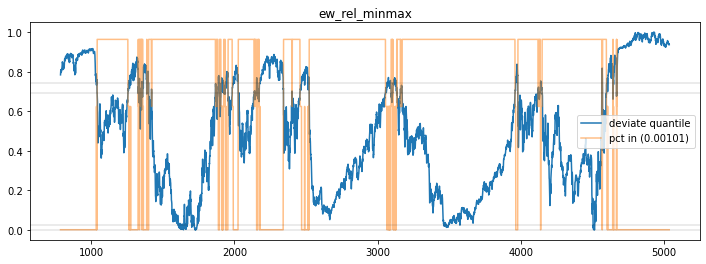

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.3896279966305407
Refitting current best...
Current best ma returns: 3.6898711555400796
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 3.717700807414666
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.3896279966305407
Refitting current best...
Current best ew_ma returns: 4.163189350257594
Fraction Invested: 0.001450442695768847
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 4.163221335637129
Invested: 0.001450442695768847
New best: 4.163224623345993
Invested: 0.001450442695768847
Round: 180


Beginning rel_minm

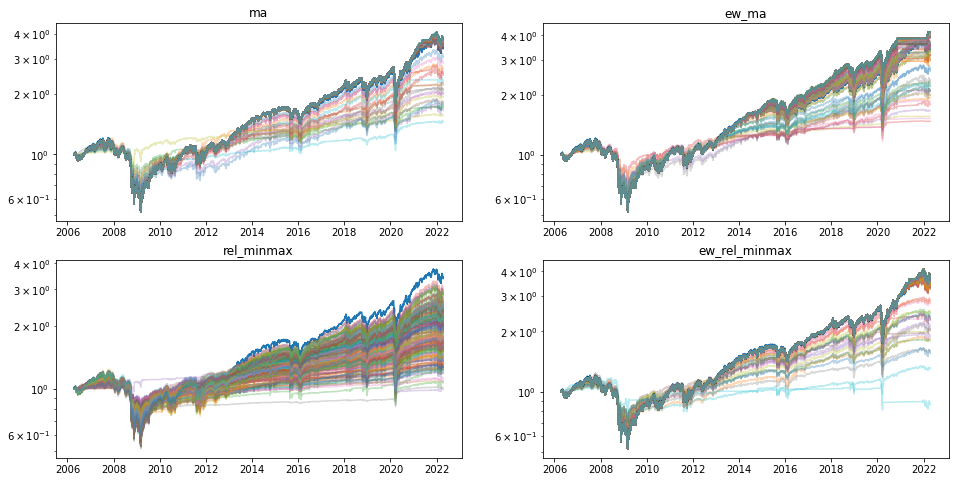

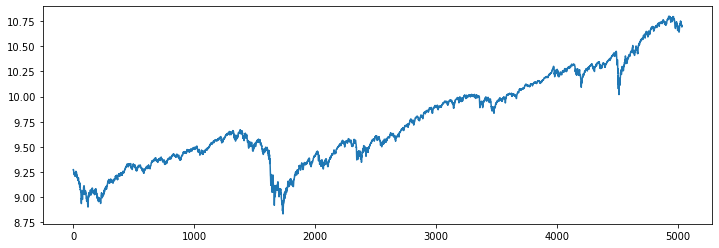

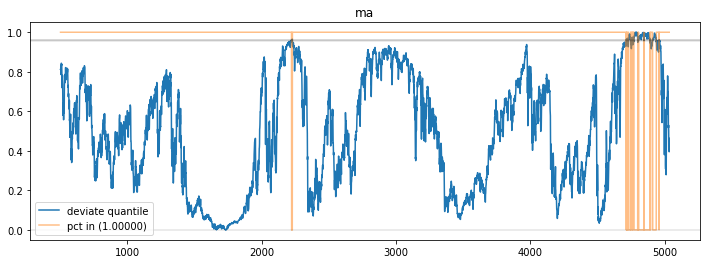

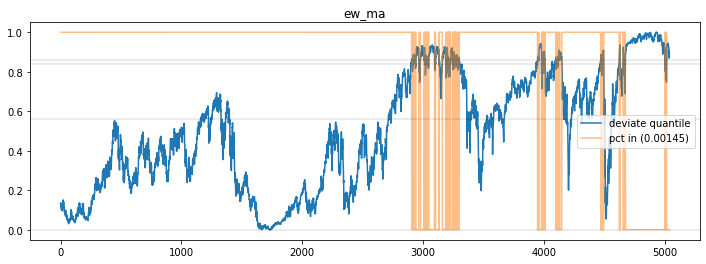

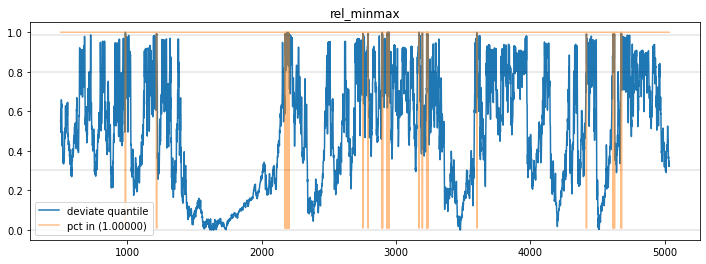

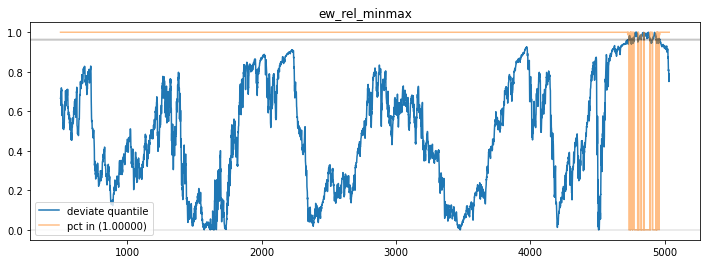

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 12.923478956244839
Refitting current best...
Current best ma returns: 14.287419852802685
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 12.923478956244839
Refitting current best...
Current best ew_ma returns: 15.138412329890684
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 12.923478956244839
Refitting current best...
Fraction Invested: 1
Beginning random search..

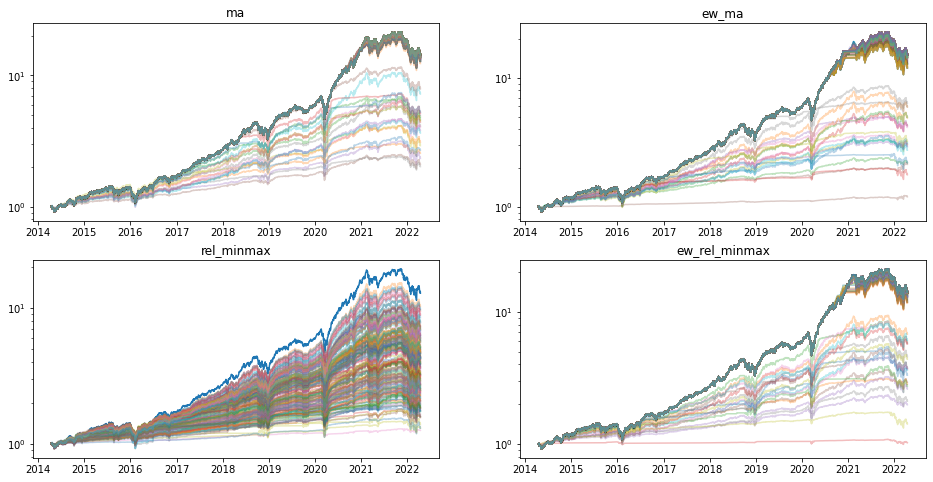

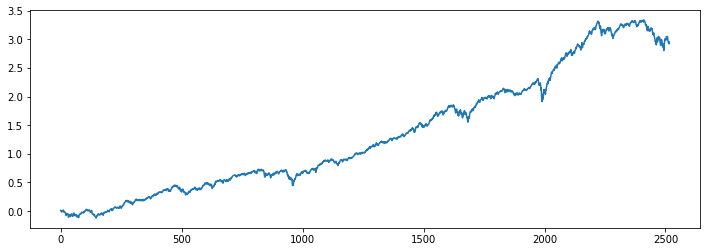

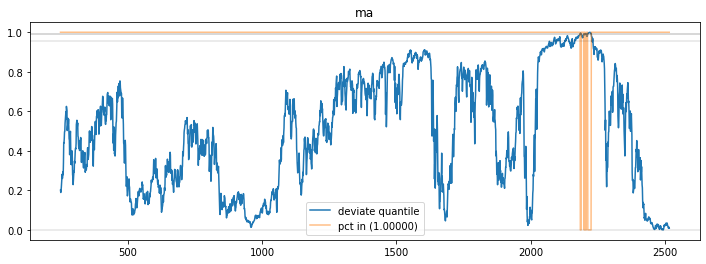

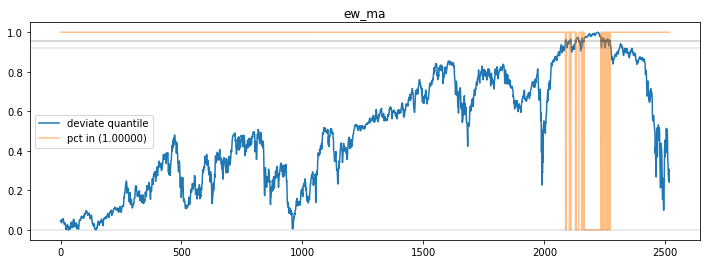

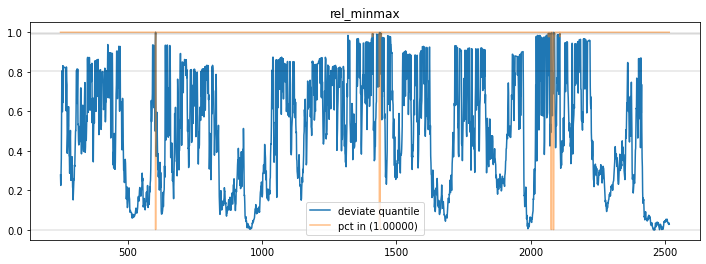

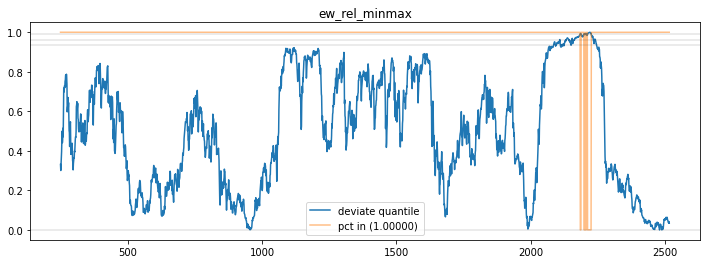

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.938383252658185
Refitting current best...
Current best ma returns: 6.493311894184898
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 6.493814520235903
Invested: 1.0
New best: 6.495295352002789
Invested: 1.0
New best: 6.497830566698351
Invested: 1.0
New best: 6.498112043909754
Invested: 1.0
New best: 6.4984670280165195
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 4.938383252658185
Refitting current best...
Current best ew_ma returns: 7.35227674327777
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
R

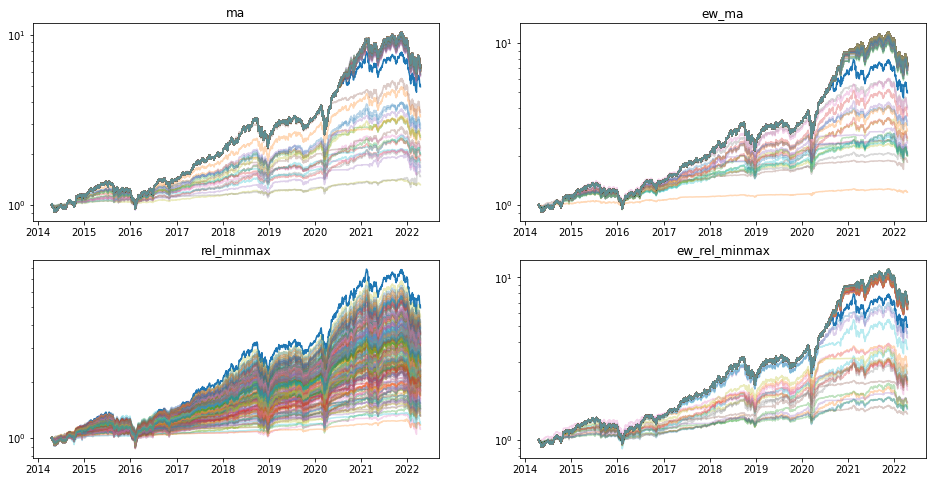

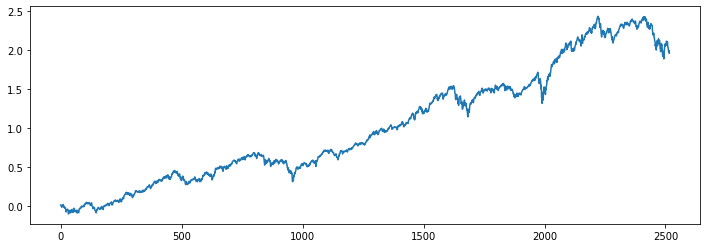

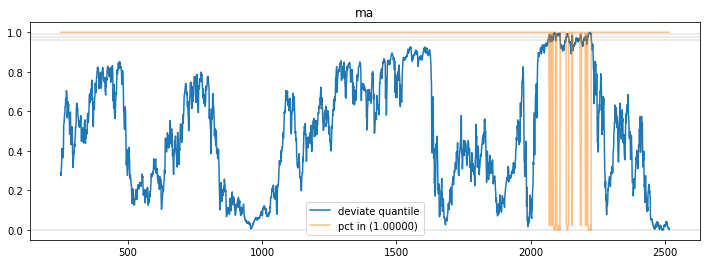

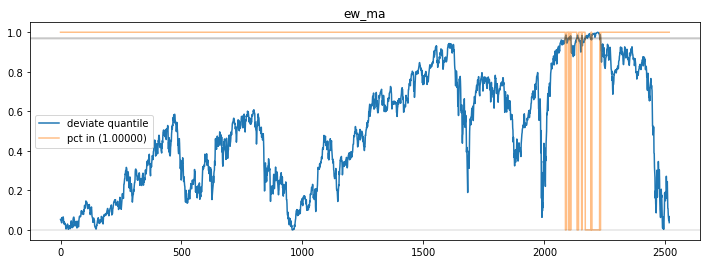

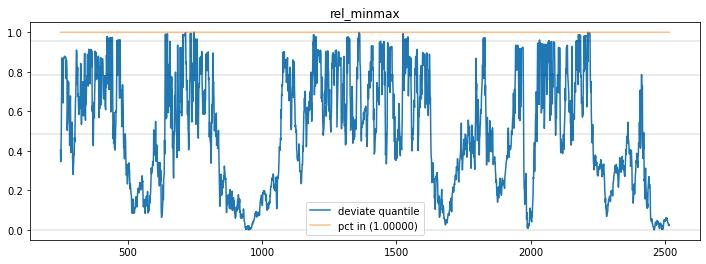

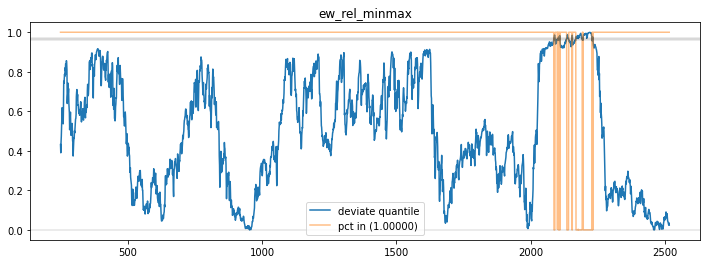

Saving mine2 params...


In [21]:
SD = 0.2213282
N_RAND = 20
N_ADJ = 180

#N_RAND = 5
#N_ADJ = 45

print('SD:', SD)
do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(
            stock_data, 
            N_CUTS, 
            best_param_set=best_params, 
            best_returns=best_returns, 
            sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [22]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = {'best_return': best_return, 'pct_in': best_pct}
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [23]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 3.6532158336348375 (ma)
  1.00000000 in
time param: 503
qs:
(0.0000 - 0.9811): 1.0000
(0.9811 - 0.9853): 1.0000
(0.9853 - 0.9871): 0.0559
(0.9871 - 1.0000): 0.0014

^IXIC:
  Best Return: 7.067425726294818 (ew_rel_minmax)
  0.99999998 in
time param: 607
qs:
(0.0000 - 0.8890): 1.0000
(0.8890 - 0.8929): 1.0000
(0.8929 - 0.8976): 0.0063
(0.8976 - 1.0000): 0.0007

^NYA:
  Best Return: 2.5884998566810364 (ma)
  0.99999995 in
time param: 616
qs:
(0.0000 - 0.8206): 1.0000
(0.8206 - 0.8463): 1.0000
(0.8463 - 0.8672): 0.9995
(0.8672 - 1.0000): 0.0010

^W5000:
  Best Return: 4.163224623345993 (ew_ma)
  0.00145044 in
time param: 503
qs:
(0.0000 - 0.5589): 1.0000
(0.5589 - 0.8390): 1.0000
(0.8390 - 0.8588): 0.9998
(0.8588 - 1.0000): 0.0015

mine1:
  Best Return: 15.138412329890684 (ew_ma)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.9218): 1.0000
(0.9218 - 0.9565): 1.0000
(0.9565 - 0.9566): 0.9473
(0.9566 - 1.0000): 0.0005

mine2:
  Best Return: 7.35227674327777 (ew_ma)
  

{'^GSPC': {'best_return': 3.6532158336348375, 'pct_in': 1.0},
 '^IXIC': {'best_return': 7.067425726294818, 'pct_in': 0.9999999828639686},
 '^NYA': {'best_return': 2.5884998566810364, 'pct_in': 0.9999999514344489},
 '^W5000': {'best_return': 4.163224623345993, 'pct_in': 0.001450442695768847},
 'mine1': {'best_return': 15.138412329890684, 'pct_in': 1.0},
 'mine2': {'best_return': 7.35227674327777, 'pct_in': 1.0}}

In [24]:
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]['best_return']
    den = do_nothing_returns[stock]
    weight = (num / den) - 1
    if weight <= 0:
        weight = 0
    if stock.startswith('mine'):
        weight /= 2
    best_returns[stock]['weight'] = weight
best_returns

{'^GSPC': {'best_return': 3.6532158336348375,
  'pct_in': 1.0,
  'weight': 0.06897932971940812},
 '^IXIC': {'best_return': 7.067425726294818,
  'pct_in': 0.9999999828639686,
  'weight': 0.22341795007171994},
 '^NYA': {'best_return': 2.5884998566810364,
  'pct_in': 0.9999999514344489,
  'weight': 0.29211715995183485},
 '^W5000': {'best_return': 4.163224623345993,
  'pct_in': 0.001450442695768847,
  'weight': 0.22822463924786018},
 'mine1': {'best_return': 15.138412329890684,
  'pct_in': 1.0,
  'weight': 0.08569416103608662},
 'mine2': {'best_return': 7.35227674327777,
  'pct_in': 1.0,
  'weight': 0.2444011903410147}}

In [25]:
with open(f'{DATA}/qp_{N_YEARS}_weights.json', 'w') as f:
    json.dump(best_returns, f)

In [27]:
!say qp 20 is dunzo